In [225]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [226]:
import seaborn as sns
sns.set_style("dark")
data = sns.load_dataset('mpg')[['mpg','cylinders','displacement',
                                'horsepower','weight','acceleration','model_year','origin']]

In [227]:
data = pd.get_dummies(data,'origin')

In [228]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_europe,origin_japan,origin_usa
0,18.0,8,307.0,130.0,3504,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449,10.5,70,0,0,1


In [229]:
df = data.sample(len(data))

In [230]:
formula = 'mpg ~'
for col in df.columns:
    if col != 'mpg':
        formula += f' {col} +'
formula[:-1]

'mpg ~ cylinders + displacement + horsepower + weight + acceleration + model_year + origin_europe + origin_japan + origin_usa '

In [231]:
results = smf.ols(formula[:-1], data=df).fit()

In [232]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     224.5
Date:                Wed, 13 May 2020   Prob (F-statistic):          1.79e-139
Time:                        15:14:30   Log-Likelihood:                -1020.5
No. Observations:                 392   AIC:                             2059.
Df Residuals:                     383   BIC:                             2095.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -12.0951      3.482     -3.474

# T-test

Null hypothesis: Has no effect.

Alternative hypothesis: Has an effect in either direction.

A small p-value indicates strong evidence against the null hypothesis and a high p-value indicates a strong evidence in favor of the null hypothesis.

The cutoff value $\alpha$ is generally 0.05. It is also known as the "significance level". It is defined as the probability of making the wrong decision.

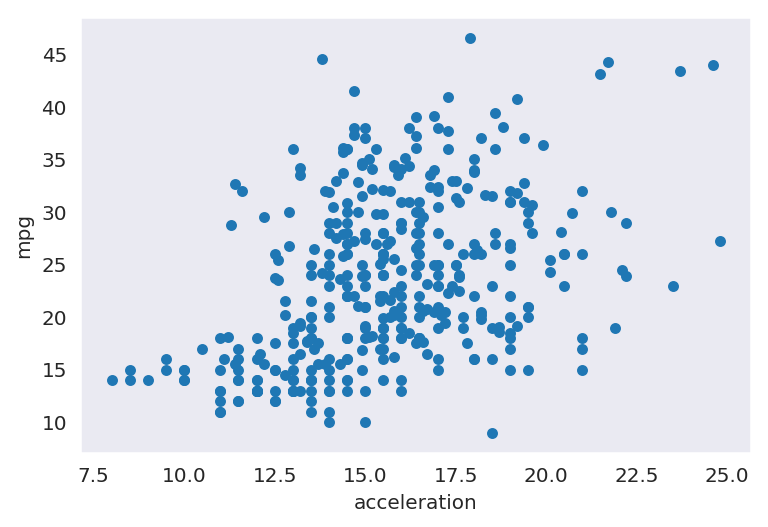

In [233]:
data.plot(kind="scatter",x='acceleration',y='mpg')

# Feature Importance

## Permutation Importance

In [303]:
data = sns.load_dataset('titanic').drop(["alive","adult_male","who","class",'embarked'],axis=1)

In [304]:
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,deck,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,NaN,Southampton,False
1,1,1,female,38.0,1,0,71.2833,C,Cherbourg,False
2,1,3,female,26.0,0,0,7.9250,NaN,Southampton,True
3,1,1,female,35.0,1,0,53.1000,C,Southampton,False
4,0,3,male,35.0,0,0,8.0500,NaN,Southampton,True


In [305]:
hot_cols = ['pclass','sex','sibsp','parch','deck','embark_town','alone']

In [306]:
df = pd.get_dummies(data,columns=hot_cols)
df.fillna(df.median(),inplace=True)

In [307]:
df.head()

,survived,age,fare,pclass_1,pclass_2,pclass_3,sex_female,sex_male,sibsp_0,sibsp_1,...,deck_C,deck_D,deck_E,deck_F,deck_G,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,alone_False,alone_True
0,0,22.0,7.2500,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,1,1,0
1,1,38.0,71.2833,1,0,0,1,0,0,1,...,1,0,0,0,0,1,0,0,1,0
2,1,26.0,7.9250,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,1,0,1
3,1,35.0,53.1000,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,1,0
4,0,35.0,8.0500,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,1,0,1


In [308]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [309]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("survived",axis=1), df.survived, random_state=0)

In [310]:
rf = RandomForestClassifier(oob_score=True).fit(X_train,y_train)
print(rf.oob_score_)

0.7874251497005988


In [311]:
%%time
imp = permutation_importance(rf, X_test, y_test,n_repeats=30,random_state=0)

CPU times: user 12 s, sys: 21.4 ms, total: 12 s
Wall time: 12 s


In [312]:
pd.DataFrame(dict(feat=X_test.columns,importance=imp.importances_mean)).sort_values(by='importance',ascending=False)[:10]

,feat,importance
5,sex_female,0.053214
0,age,0.025112
6,sex_male,0.022123
1,fare,0.017489
4,pclass_3,0.017190
23,deck_C,0.003886
25,deck_E,0.002691
29,embark_town_Queenstown,0.001794
14,parch_0,0.000299
12,sibsp_5,0.000149


In [313]:
pd.DataFrame(dict(feat=X_test.columns,importance=rf.feature_importances_)).sort_values(by='importance',ascending=False)[:10]

,feat,importance
0,age,0.235417
1,fare,0.214947
5,sex_female,0.140418
6,sex_male,0.124057
4,pclass_3,0.044184
2,pclass_1,0.025750
25,deck_E,0.018253
30,embark_town_Southampton,0.016408
28,embark_town_Cherbourg,0.015818
3,pclass_2,0.015608


# Understanding the contributions from each future

With Decision Trees you call plot the tree and traverse the path at its entirety. This is could be seen as the gold standard for explainability of your model. However, not many models allow this. A random forest model while seemingly black box does allow for some interpretability on its predictions.

In [314]:
# !pip install treeinterpreter

In [315]:
from treeinterpreter import treeinterpreter as ti
import numpy as np

In [316]:
df.head()

,survived,age,fare,pclass_1,pclass_2,pclass_3,sex_female,sex_male,sibsp_0,sibsp_1,...,deck_C,deck_D,deck_E,deck_F,deck_G,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,alone_False,alone_True
0,0,22.0,7.2500,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,1,1,0
1,1,38.0,71.2833,1,0,0,1,0,0,1,...,1,0,0,0,0,1,0,0,1,0
2,1,26.0,7.9250,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,1,0,1
3,1,35.0,53.1000,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,1,0
4,0,35.0,8.0500,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,1,0,1


In [317]:
indexes = [874,629,754]

In [318]:
df.loc[indexes]

,survived,age,fare,pclass_1,pclass_2,pclass_3,sex_female,sex_male,sibsp_0,sibsp_1,...,deck_C,deck_D,deck_E,deck_F,deck_G,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,alone_False,alone_True
874,1,28.0,24.0000,0,1,0,1,0,0,1,...,0,0,0,0,0,1,0,0,1,0
629,0,28.0,7.7333,0,0,1,0,1,1,0,...,0,0,0,0,0,0,1,0,0,1
754,1,48.0,65.0000,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,1,1,0


In [319]:
prediction, bias, contributions = ti.predict(rf,X_train.loc[indexes])

In [320]:
for i in range(len(bias)):
    print("Instance",i)
    print("Bias (trainset mean)", bias[i][1].round(2))
    print(f"Prediction {prediction[i][1].round(2)} vs Actual {y_train.loc[indexes].iloc[i]}")
    print("Feature contributions:")
    for c, feature in sorted(zip(contributions[i][:,1], X_train.columns.tolist()), key=lambda x: -abs(x[0])):
        if round(c, 3) > 0:
            print(feature, round(c, 3))
    print ("-"*20) 

Instance 0
Bias (trainset mean) 0.39
Prediction 0.95 vs Actual 1
Feature contributions:
sex_female 0.163
sex_male 0.147
pclass_3 0.093
age 0.051
pclass_2 0.047
embark_town_Cherbourg 0.042
fare 0.036
embark_town_Southampton 0.027
alone_True 0.016
alone_False 0.007
sibsp_8 0.003
sibsp_3 0.002
sibsp_4 0.001
parch_6 0.001
--------------------
Instance 1
Bias (trainset mean) 0.39
Prediction 0.01 vs Actual 0
Feature contributions:
embark_town_Southampton 0.013
deck_F 0.001
sibsp_0 0.001
--------------------
Instance 2
Bias (trainset mean) 0.39
Prediction 0.92 vs Actual 1
Feature contributions:
sex_female 0.174
pclass_3 0.133
sex_male 0.127
fare 0.067
pclass_2 0.064
parch_0 0.034
alone_True 0.015
deck_C 0.008
alone_False 0.007
sibsp_1 0.007
sibsp_8 0.007
parch_2 0.003
sibsp_3 0.003
parch_5 0.002
sibsp_4 0.002
parch_6 0.001
--------------------
